In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [2]:
sdir=r'C:\Users\LENOVO\Pictures\Contoh Dataset\Dataset Klasifikasi Hama' 


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths            labels
0  C:\Users\LENOVO\Pictures\Contoh Dataset\Datase...  Hama Putih Palsu
1  C:\Users\LENOVO\Pictures\Contoh Dataset\Datase...  Hama Putih Palsu
2  C:\Users\LENOVO\Pictures\Contoh Dataset\Datase...  Hama Putih Palsu
3  C:\Users\LENOVO\Pictures\Contoh Dataset\Datase...  Hama Putih Palsu
4  C:\Users\LENOVO\Pictures\Contoh Dataset\Datase...  Hama Putih Palsu
Hama Putih Palsu                  301
Penggerek Batang Padi Bergaris    301
Penggerek Batang Padi Kuning      301
Walangsangit                      301
Wereng Coklat                     301
Wereng Hijau                      301
Name: labels, dtype: int64


In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1444   test_df length:  181   valid_df length:  181


In [4]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  1   test steps:  181
Found 1444 validated image filenames belonging to 6 classes.
Found 181 validated image filenames belonging to 6 classes.
Found 181 validated image filenames belonging to 6 classes.
['Hama Putih Palsu', 'Penggerek Batang Padi Bergaris', 'Penggerek Batang Padi Kuning', 'Walangsangit', 'Wereng Coklat', 'Wereng Hijau']


In [5]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

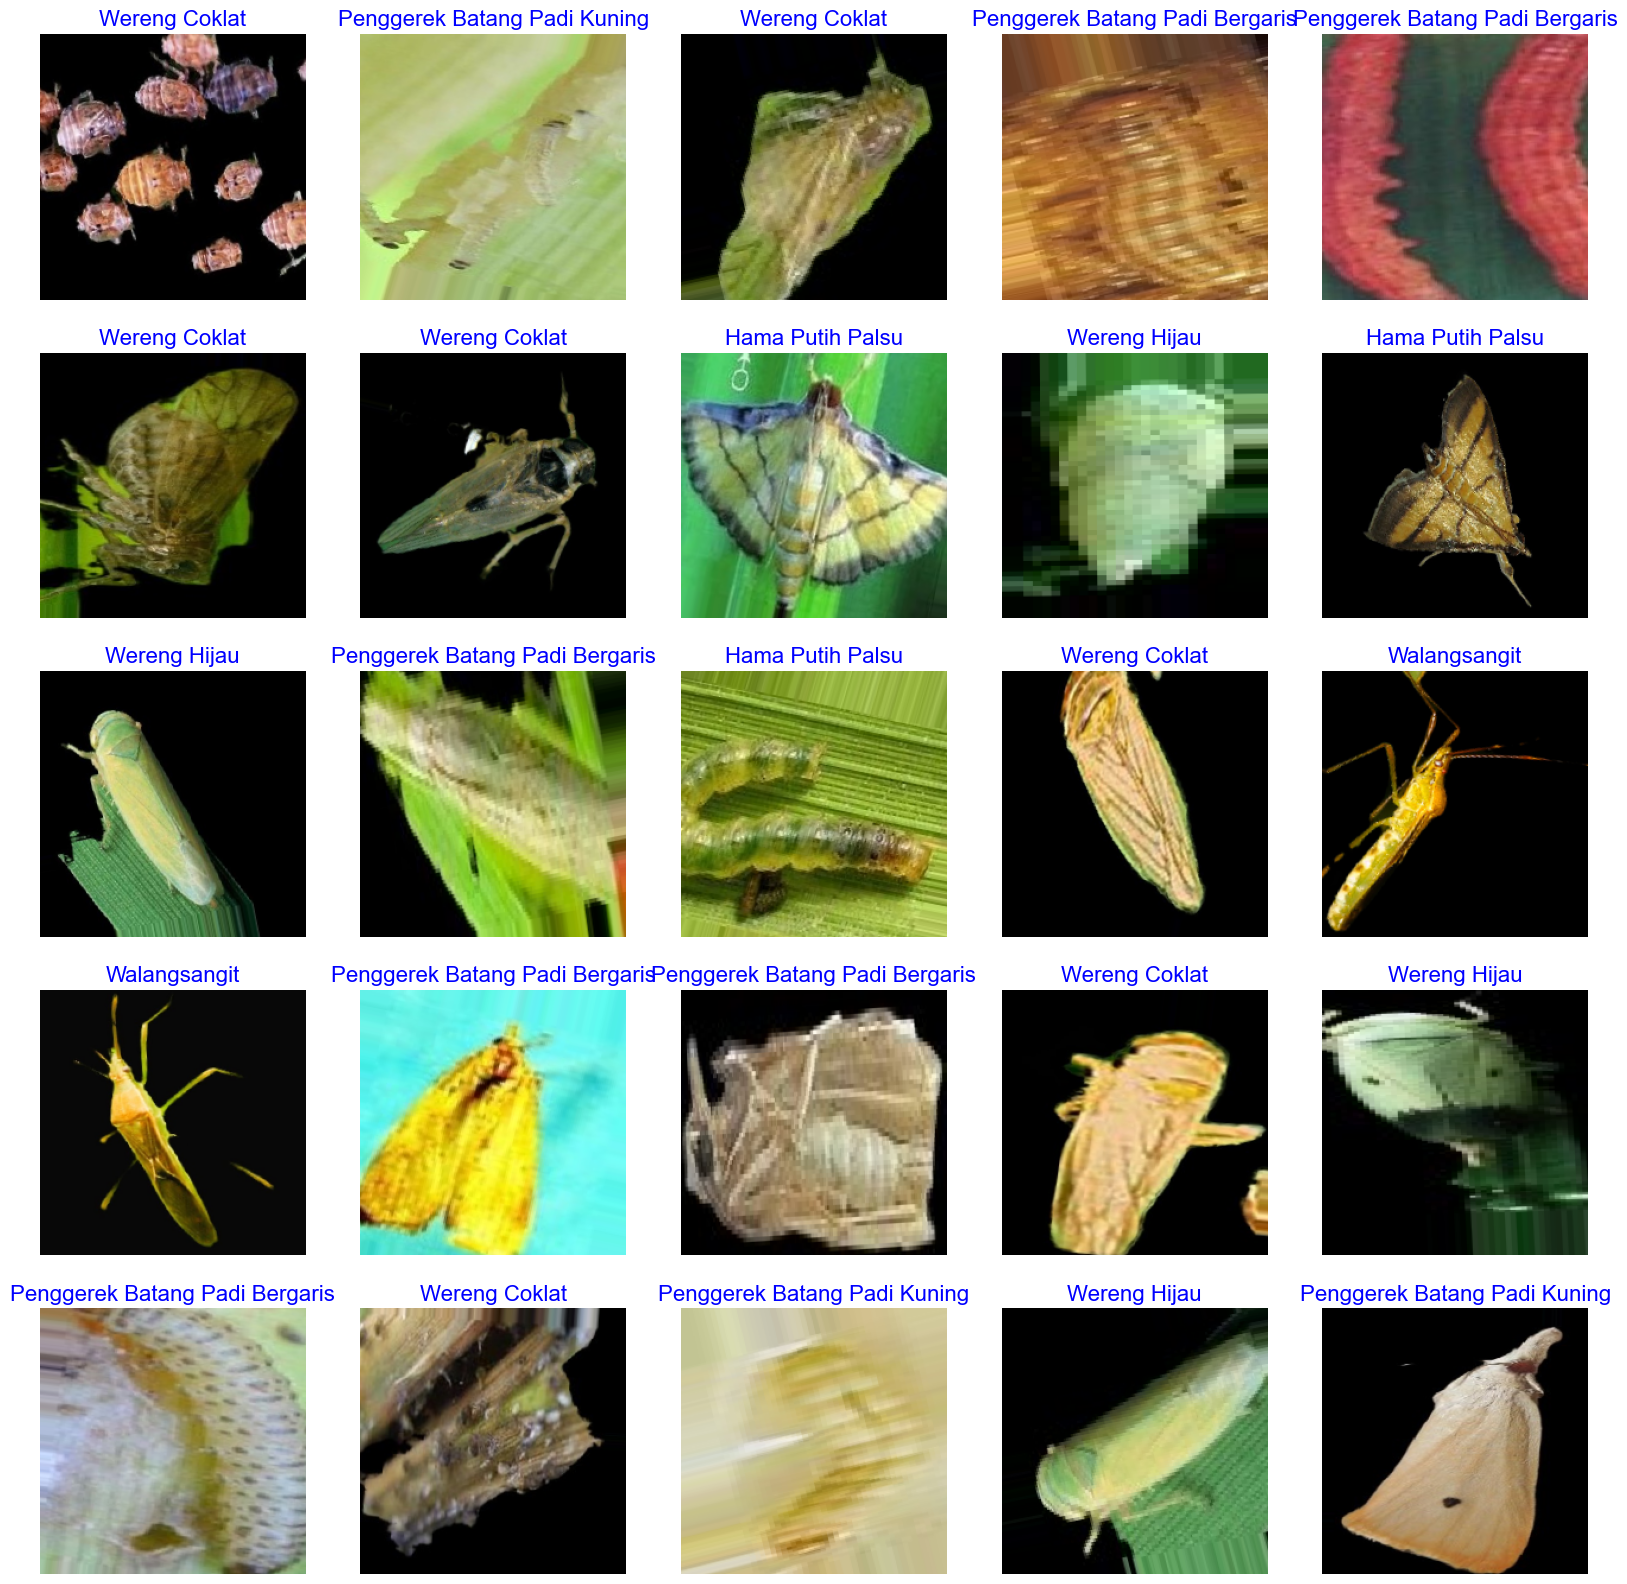

In [6]:
show_image_samples(train_gen)

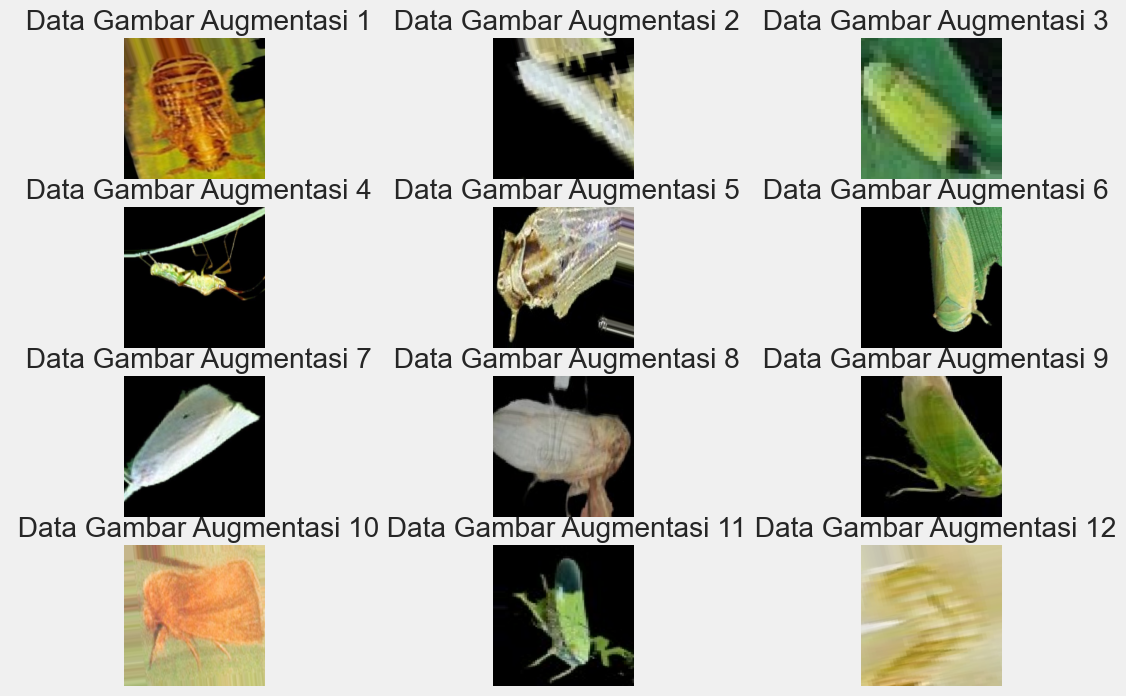

In [27]:
import matplotlib.pyplot as plt

# Ambil beberapa gambar hasil augmentasi dari aliran data pelatihan
augmented_images, _ = next(train_gen)

# Tampilkan beberapa gambar hasil augmentasi
plt.figure(figsize=(12, 8))
for i in range(12):  # Tampilkan 10 gambar
    plt.subplot(4, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f" Data Gambar Augmentasi {i+1}")
    plt.axis('off')

plt.show()


In [7]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [9]:
base_model.trainable = False

In [12]:
model_name='Azhari'
print("Building model with", base_model)
model = tf.keras.Sequential([
           
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x000001C341DEE200>


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1734      
                                                      

In [14]:
epochs =50

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/50
23/23 [==============================] - 147s 6s/step - loss: 1.6015 - accuracy: 0.3733 - val_loss: 1.1834 - val_accuracy: 0.5193
Epoch 2/50
23/23 [==============================] - 153s 7s/step - loss: 1.2038 - accuracy: 0.5305 - val_loss: 0.8778 - val_accuracy: 0.7238
Epoch 3/50
23/23 [==============================] - 152s 7s/step - loss: 1.0000 - accuracy: 0.6177 - val_loss: 0.6204 - val_accuracy: 0.7845
Epoch 4/50
23/23 [==============================] - 156s 7s/step - loss: 0.7321 - accuracy: 0.7285 - val_loss: 0.4616 - val_accuracy: 0.8343
Epoch 5/50
23/23 [==============================] - 159s 7s/step - loss: 0.6287 - accuracy: 0.7673 - val_loss: 0.5232 - val_accuracy: 0.8232
Epoch 6/50
23/23 [==============================] - 147s 6s/step - loss: 0.5478 - accuracy: 0.8019 - val_loss: 0.4313 - val_accuracy: 0.8232
Epoch 7/50
23/23 [==============================] - 144s 6s/step - loss: 0.5233 - accuracy: 0.8089 - val_loss: 0.4527 - val_accuracy: 0.8453
Epoch 8/50
23

In [15]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [16]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [17]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

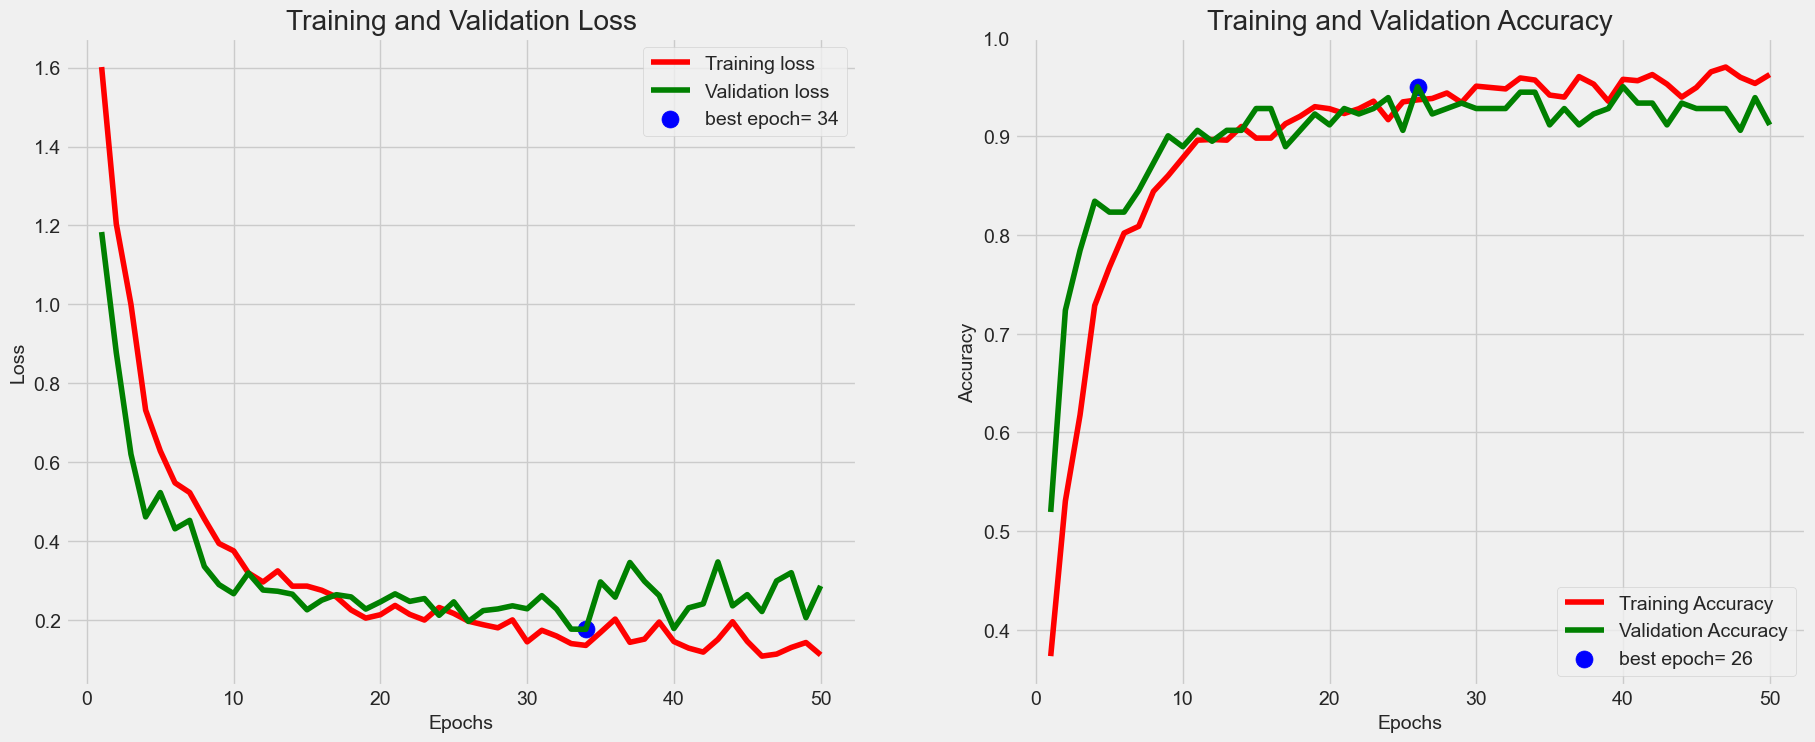

181/181 [==============================] - 15s 82ms/step - loss: 0.3771 - accuracy: 0.9171
accuracy on the test set is 91.71 %



C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
tr_plot(history,0)
save_dir=r'./plot akurasi'
subject='Hama Exception'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)

model.save(save_loc)
 

181/181 [==============================] - 17s 93ms/step


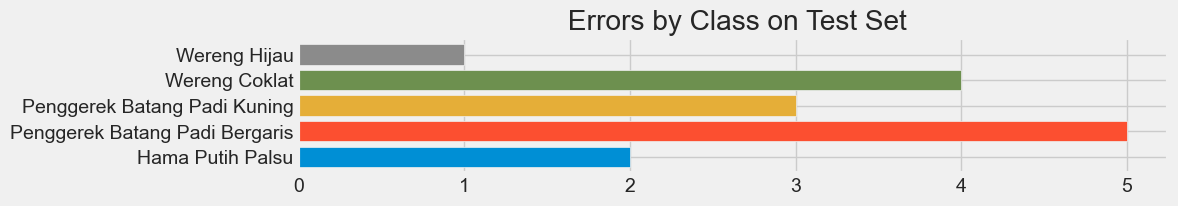

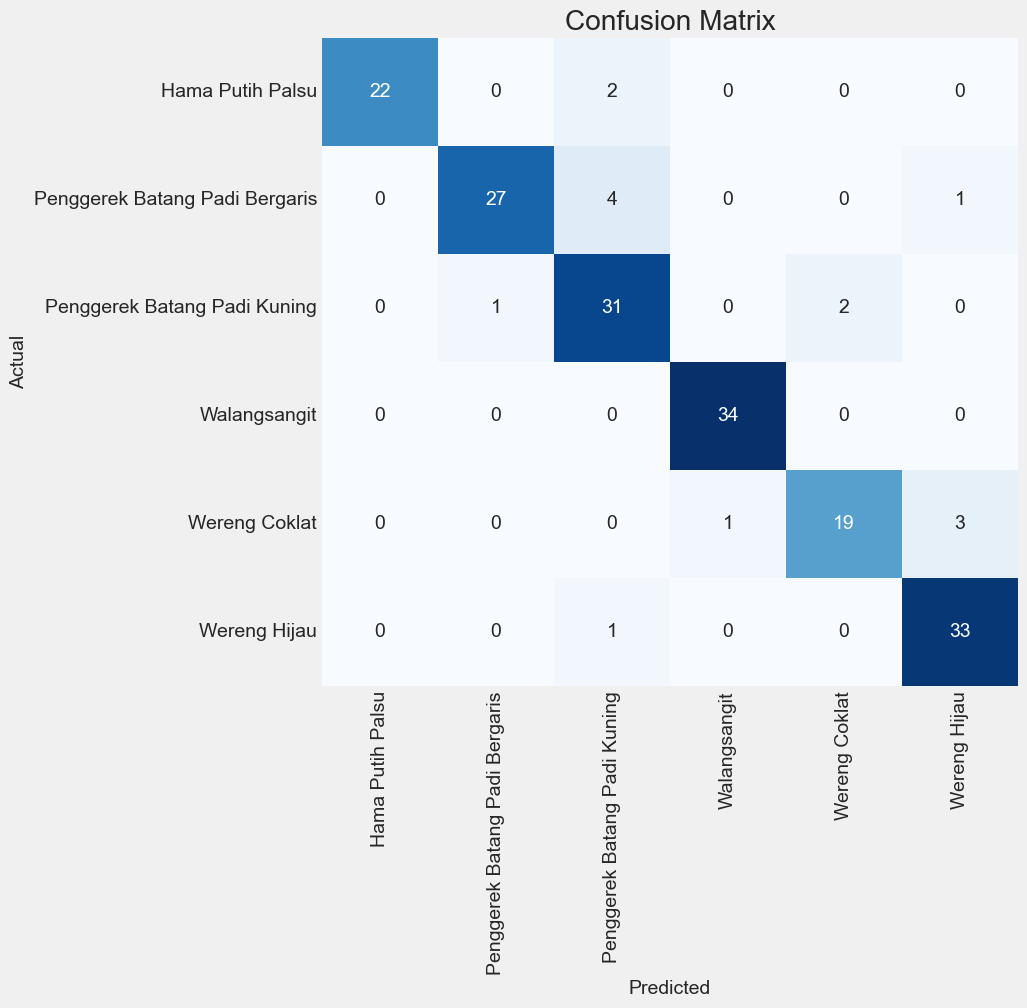

Classification Report:
----------------------
                                 precision    recall  f1-score   support

              Hama Putih Palsu       1.00      0.92      0.96        24
Penggerek Batang Padi Bergaris       0.96      0.84      0.90        32
  Penggerek Batang Padi Kuning       0.82      0.91      0.86        34
                  Walangsangit       0.97      1.00      0.99        34
                 Wereng Coklat       0.90      0.83      0.86        23
                  Wereng Hijau       0.89      0.97      0.93        34

                      accuracy                           0.92       181
                     macro avg       0.92      0.91      0.92       181
                  weighted avg       0.92      0.92      0.92       181



In [35]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  